In [ ]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

In [ ]:
# from google.colab import files

# files.upload()

{}

In [ ]:
# 데이터 입력 
import openpyxl
filename = "상명대_전력수요예측_지수평활 sheet1.xlsx" 
book = openpyxl.load_workbook(filename) #엑셀파일 book 변수에 저장
sheet=book.worksheets[0] #첫번째 워크시트 저장

In [ ]:
 data = []
 for row in sheet.rows: #전체 행에대하여 반복 실행
   data.append([
              row[0].value, #1열 데이터
              row[1].value, #2열 데이터
              row[2].value, #3열 데이터
              row[3].value, #4열 데이터
              row[4].value, #5열 데이터
              row[5].value  #6열 데이터
              ])

In [ ]:
import math
import pandas as pd
import numpy as np
data=pd.DataFrame(data[3:])
data.columns=["Name","No","Date","Time","P.D","Temp"]
data

,Name,No,Date,Time,P.D,Temp
0,신정,8,2018-01-01,1,6151.290,-3.2
1,신정,8,2018-01-01,2,6035.190,-3.3
2,신정,8,2018-01-01,3,6000.090,-3.7
3,신정,8,2018-01-01,4,5970.930,-4.0
4,신정,8,2018-01-01,5,6025.200,-4.2
...,...,...,...,...,...,...
8755,0,1,2018-12-31,20,7457.955,-3.7
8756,0,1,2018-12-31,21,7005.975,-4.6
8757,0,1,2018-12-31,22,6709.110,-5.4
8758,0,1,2018-12-31,23,6332.730,-5.2


In [ ]:
#계절
from datetime import date

date_=[]
a=len(data)
for i in range(0,a):
    month=data['Date'][i].month
    if(i<a and 3<=month<=5):
        date__='spring'
        date_.append(date__)
    elif(i<a and 6<=month<=8):
        date__='summer'
        date_.append(date__)
    elif(i<a and 9<=month<=11):
        date__='fall'
        date_.append(date__)
    elif(i<a and (month==12 or 2 or 1)):
        date__='winter'
        date_.append(date__)
data['season']=date_

#**전력만 사용**

In [ ]:
#계절별 데이터 가져오기  
def find_season(W_season):
  is_season_data = data['season'] == W_season
  season_data = data[is_season_data]
  heat_data=season_data["P.D"]
  heat_data=pd.DataFrame(heat_data)
  return heat_data

In [ ]:
data_=find_season('winter')
data_

,P.D
0,6151.290
1,6035.190
2,6000.090
3,5970.930
4,6025.200
...,...
8755,7457.955
8756,7005.975
8757,6709.110
8758,6332.730


In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data):
  whole_day=len(data)/24
  train_day=whole_day*0.8
  train=int(train_day*24) 
  return data[:train],data[-24:]

In [ ]:
# transform list into supervised learning format
def series_to_supervised(m_data, n_in, n_out=1):
	m_data.dropna(inplace=True)
	train_series = [] 
	target_series = [] 
  
	for i in range(0, len(m_data)-2):
		row = [] # row represents a train series, in this case, [[111, -1], [112, -2]]
		count = i # count is the variable to access the target value, in this case, 113
		for j in range(2):
        # a row = [111, -1]
			row.append([value for value in m_data.iloc[i+j]])
			count += 1
		train_series.append(row)
		target_series.append(m_data.iloc[count].values[0])
    # ----
	train_series = np.array(train_series, dtype="float32")
	target_series = np.array(target_series, dtype="float32")
	return train_series, target_series

In [ ]:
def measure_error(actual, predicted):
  actual=np.array(actual)
  predicted=np.array(predicted)
  result=np.mean(abs(actual-predicted)/actual)*100
  return result

In [ ]:
# fit a model
def model_fit(train, config):  
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config  #config = [1, 2, 64, 3, 200, 350, 100]
	n_input = n_seq * n_steps

	# prepare data
	data = series_to_supervised(train, n_input,1)
	train_x, train_y = data[:-1], data[-1]  #train중, data[:, :-1]=마지막값 제외, data[:, -1]=마지막값
	train_x = np.asarray(train_x)
	train_x = train_x.reshape((train_x.shape[1], n_seq, n_steps, 1))  #input
 
	# define model
	model = Sequential()
 #TimeDistributed= 각 스텝마다 cost(오류)를 계산해서 하위 스텝으로 오류를 전파하여 각 weight를 업데이트하라는 의미
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu', input_shape=(None,n_steps,1))))
	# model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu')))
#	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D()))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1)
	return model

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config):  
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
	# forecast
	yhat = model.predict(x_input,verbose=0)
	return yhat[0]

In [ ]:
import matplotlib.pyplot as plt
def draw_graph(test,predictions):
	fig = plt.figure(figsize=(10, 5))
	ax1 = fig.add_subplot(1, 1, 1)
	ax1.plot(test, 'b', label='Original')
	ax1.plot(predictions, 'r', label='Prediction')
	ax1.legend(loc="lower right")

In [ ]:
# walk-forward validation for univariate(단변량=종속변수 한개) data
#학습 및 에러계산
def walk_forward_validation(data, n_test, cfg):   
	predictions = list()
	# split dataset
	train, test = train_test_split(data) 
	# fit model
	model = model_fit(train, cfg)
	print('finish training')
	# seed history with training dataset
	history = [x for x in train.values] 
	test=[x for x in test.values]  

	# step over each time-step in the test set
	for i in range(len(test)):
		yhat = model_predict(model, history , cfg)   #predict에 history를 넣는이유
		# store forecast in list of, 예측값모음=predictions
		predictions.append(yhat)  
		# add actual observation to history for the next loop
		history.append(test[i])
		test_=np.array(test)
  
	# estimate prediction errorrint("pre") 에러율 계산 
	error = measure_error(test_, predictions)  
	print(test_)
	print(predictions)
	print(' > %.3f' % error)
	draw_graph(test_,predictions)
	f=open('output.csv','w')
	for i in range(len(test_)):
		f.write(str(test_[i][0])+','+str(predictions[i][0])+'\n')
	f.close()
	return error

In [ ]:
# repeat evaluation of a config
#전체 에러 계산 
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]  #error 저장
	return scores

In [ ]:
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f error (+/- %.3f)' % (name, scores_m, score_std))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 11ms/step - loss: 56036205.6842
Epoch 2/350
18/18 [==============================] - 0s 10ms/step - loss: 3755311.2599
Epoch 3/350
18/18 [==============================] - 0s 10ms/step - loss: 1161449.8125
Epoch 4/350
18/18 [==============================] - 0s 9ms/step - loss: 760466.1447
Epoch 5/350
18/18 [==============================] - 0s 10ms/step - loss: 541166.1809
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 491597.9128
Epoch 7/350
18/18 [==============================] - 0s 11ms/step - loss: 471721.2664
Epoch 8/350
18/18 [==============================] - 0s 9ms/step - loss: 325802.2516
Epoch 9/350
18/18 [==============================] - 0s 9ms/step - loss: 363249.6497
Epoch 10/350
18/18 [==============================] - 0s 9ms/step - loss: 329732.8339
Epoch 11/350
18/18 [==============================] - 0s 10ms/step - loss: 312849.1727
Epoch 12/350
18/18 [==============================] 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 64222730.3158
Epoch 2/350
18/18 [==============================] - 0s 9ms/step - loss: 8514110.0526
Epoch 3/350
18/18 [==============================] - 0s 10ms/step - loss: 1602522.6217
Epoch 4/350
18/18 [==============================] - 0s 9ms/step - loss: 856163.9605
Epoch 5/350
18/18 [==============================] - 0s 10ms/step - loss: 530771.0872
Epoch 6/350
18/18 [==============================] - 0s 9ms/step - loss: 534761.7286
Epoch 7/350
18/18 [==============================] - 0s 9ms/step - loss: 417641.4803
Epoch 8/350
18/18 [==============================] - 0s 9ms/step - loss: 354974.1875
Epoch 9/350
18/18 [==============================] - 0s 9ms/step - loss: 334593.5905
Epoch 10/350
18/18 [==============================] - 0s 9ms/step - loss: 325696.5551
Epoch 11/350
18/18 [==============================] - 0s 11ms/step - loss: 296565.2401
Epoch 12/350
18/18 [==============================] - 0s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 52395951.3684
Epoch 2/350
18/18 [==============================] - 0s 9ms/step - loss: 4654429.5132
Epoch 3/350
18/18 [==============================] - 0s 10ms/step - loss: 1328778.2368
Epoch 4/350
18/18 [==============================] - 0s 9ms/step - loss: 798523.7730
Epoch 5/350
18/18 [==============================] - 0s 10ms/step - loss: 614818.7286
Epoch 6/350
18/18 [==============================] - 0s 9ms/step - loss: 540151.4803
Epoch 7/350
18/18 [==============================] - 0s 10ms/step - loss: 474313.7451
Epoch 8/350
18/18 [==============================] - 0s 10ms/step - loss: 398831.6727
Epoch 9/350
18/18 [==============================] - 0s 9ms/step - loss: 369366.7385
Epoch 10/350
18/18 [==============================] - 0s 9ms/step - loss: 304883.1373
Epoch 11/350
18/18 [==============================] - 0s 10ms/step - loss: 324576.8191
Epoch 12/350
18/18 [==============================] - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 58551145.0526
Epoch 2/350
18/18 [==============================] - 0s 10ms/step - loss: 4022465.3487
Epoch 3/350
18/18 [==============================] - 0s 10ms/step - loss: 1830803.0329
Epoch 4/350
18/18 [==============================] - 0s 9ms/step - loss: 835945.5954
Epoch 5/350
18/18 [==============================] - 0s 11ms/step - loss: 717077.2697
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 622354.4342
Epoch 7/350
18/18 [==============================] - 0s 9ms/step - loss: 540920.3438
Epoch 8/350
18/18 [==============================] - 0s 9ms/step - loss: 566759.3174
Epoch 9/350
18/18 [==============================] - 0s 10ms/step - loss: 475061.8997
Epoch 10/350
18/18 [==============================] - 0s 11ms/step - loss: 502692.7220
Epoch 11/350
18/18 [==============================] - 0s 10ms/step - loss: 377962.4342
Epoch 12/350
18/18 [==============================] 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 10ms/step - loss: 61034815.1579
Epoch 2/350
18/18 [==============================] - 0s 10ms/step - loss: 4721556.3289
Epoch 3/350
18/18 [==============================] - 0s 10ms/step - loss: 1987984.4868
Epoch 4/350
18/18 [==============================] - 0s 10ms/step - loss: 839244.8289
Epoch 5/350
18/18 [==============================] - 0s 9ms/step - loss: 666983.6184
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 527383.1760
Epoch 7/350
18/18 [==============================] - 0s 10ms/step - loss: 509006.7566
Epoch 8/350
18/18 [==============================] - 0s 10ms/step - loss: 495257.8684
Epoch 9/350
18/18 [==============================] - 0s 10ms/step - loss: 365634.1743
Epoch 10/350
18/18 [==============================] - 0s 10ms/step - loss: 340723.0493
Epoch 11/350
18/18 [==============================] - 0s 10ms/step - loss: 316279.5395
Epoch 12/350
18/18 [=============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 54986342.1053
Epoch 2/350
18/18 [==============================] - 0s 9ms/step - loss: 3222718.8849
Epoch 3/350
18/18 [==============================] - 0s 11ms/step - loss: 1403473.1908
Epoch 4/350
18/18 [==============================] - 0s 10ms/step - loss: 657397.7697
Epoch 5/350
18/18 [==============================] - 0s 11ms/step - loss: 472506.0329
Epoch 6/350
18/18 [==============================] - 0s 11ms/step - loss: 398757.2599
Epoch 7/350
18/18 [==============================] - 0s 10ms/step - loss: 369271.0543
Epoch 8/350
18/18 [==============================] - 0s 13ms/step - loss: 321438.6414
Epoch 9/350
18/18 [==============================] - 0s 11ms/step - loss: 325423.8487
Epoch 10/350
18/18 [==============================] - 0s 10ms/step - loss: 304974.8503
Epoch 11/350
18/18 [==============================] - 0s 10ms/step - loss: 291975.0419
Epoch 12/350
18/18 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 62647386.9474
Epoch 2/350
18/18 [==============================] - 0s 10ms/step - loss: 5168960.6184
Epoch 3/350
18/18 [==============================] - 0s 11ms/step - loss: 1679952.2829
Epoch 4/350
18/18 [==============================] - 0s 9ms/step - loss: 695293.4408
Epoch 5/350
18/18 [==============================] - 0s 10ms/step - loss: 629763.8586
Epoch 6/350
18/18 [==============================] - 0s 11ms/step - loss: 510785.1086
Epoch 7/350
18/18 [==============================] - 0s 10ms/step - loss: 431918.0280
Epoch 8/350
18/18 [==============================] - 0s 11ms/step - loss: 431528.5954
Epoch 9/350
18/18 [==============================] - 0s 11ms/step - loss: 342204.8470
Epoch 10/350
18/18 [==============================] - 0s 9ms/step - loss: 283849.8438
Epoch 11/350
18/18 [==============================] - 0s 11ms/step - loss: 317048.2944
Epoch 12/350
18/18 [==============================]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 11ms/step - loss: 54498691.7895
Epoch 2/350
18/18 [==============================] - 0s 11ms/step - loss: 3970186.1908
Epoch 3/350
18/18 [==============================] - 0s 11ms/step - loss: 1408286.9342
Epoch 4/350
18/18 [==============================] - 0s 11ms/step - loss: 700686.0757
Epoch 5/350
18/18 [==============================] - 0s 11ms/step - loss: 576698.6447
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 505024.8849
Epoch 7/350
18/18 [==============================] - 0s 11ms/step - loss: 467212.3174
Epoch 8/350
18/18 [==============================] - 0s 11ms/step - loss: 344267.1974
Epoch 9/350
18/18 [==============================] - 0s 11ms/step - loss: 325478.5526
Epoch 10/350
18/18 [==============================] - 0s 12ms/step - loss: 315197.8766
Epoch 11/350
18/18 [==============================] - 0s 11ms/step - loss: 348640.0296
Epoch 12/350
18/18 [============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 61496457.8947
Epoch 2/350
18/18 [==============================] - 0s 10ms/step - loss: 5802835.6053
Epoch 3/350
18/18 [==============================] - 0s 10ms/step - loss: 1954243.1250
Epoch 4/350
18/18 [==============================] - 0s 10ms/step - loss: 710911.1842
Epoch 5/350
18/18 [==============================] - 0s 10ms/step - loss: 702262.5559
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 619007.7993
Epoch 7/350
18/18 [==============================] - 0s 11ms/step - loss: 484295.0197
Epoch 8/350
18/18 [==============================] - 0s 10ms/step - loss: 461389.8322
Epoch 9/350
18/18 [==============================] - 0s 11ms/step - loss: 424082.4128
Epoch 10/350
18/18 [==============================] - 0s 11ms/step - loss: 395413.8092
Epoch 11/350
18/18 [==============================] - 0s 11ms/step - loss: 333034.0543
Epoch 12/350
18/18 [=============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 11ms/step - loss: 62698964.6316
Epoch 2/350
18/18 [==============================] - 0s 10ms/step - loss: 5318913.9605
Epoch 3/350
18/18 [==============================] - 0s 11ms/step - loss: 2198883.6118
Epoch 4/350
18/18 [==============================] - 0s 11ms/step - loss: 842486.7105
Epoch 5/350
18/18 [==============================] - 0s 10ms/step - loss: 700638.4967
Epoch 6/350
18/18 [==============================] - 0s 9ms/step - loss: 558843.6283
Epoch 7/350
18/18 [==============================] - 0s 11ms/step - loss: 516999.9836
Epoch 8/350
18/18 [==============================] - 0s 9ms/step - loss: 422273.1908
Epoch 9/350
18/18 [==============================] - 0s 11ms/step - loss: 409469.4868
Epoch 10/350
18/18 [==============================] - 0s 11ms/step - loss: 358664.3059
Epoch 11/350
18/18 [==============================] - 0s 11ms/step - loss: 321254.3750
Epoch 12/350
18/18 [==============================

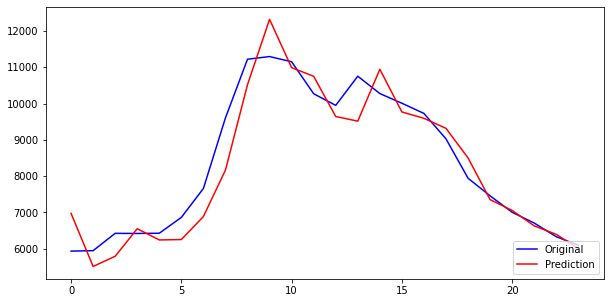

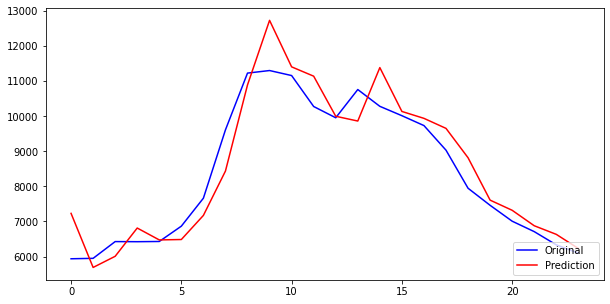

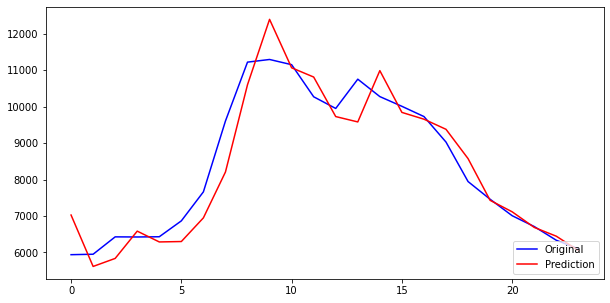

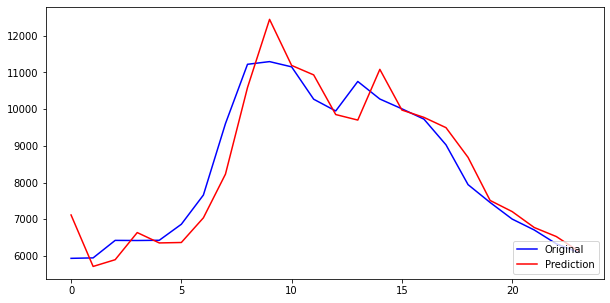

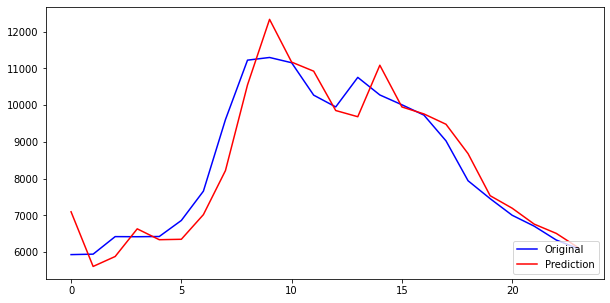

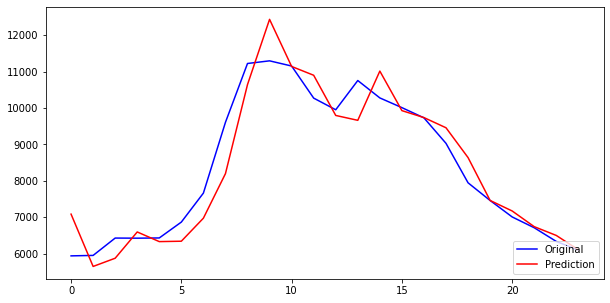

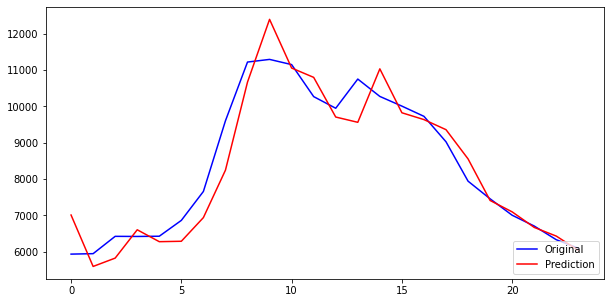

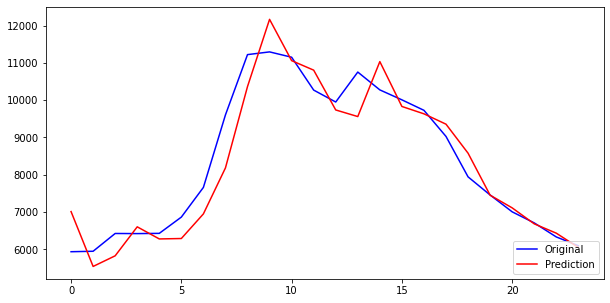

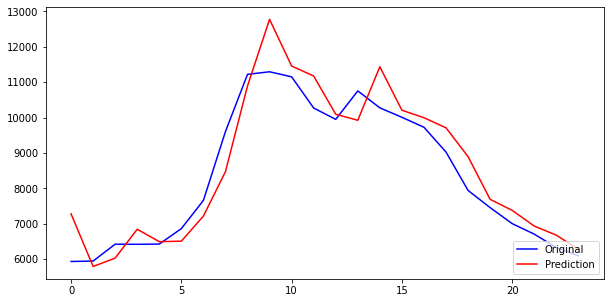

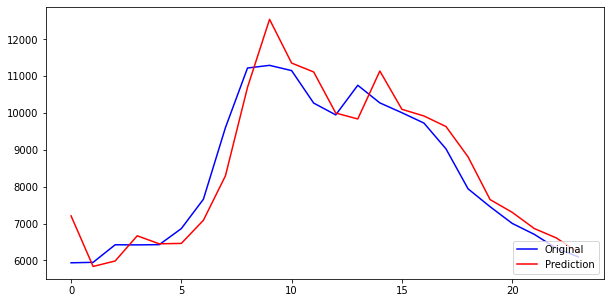

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping
# data split
n_test = 2

# define config 
# n seq: The number of subsequences within a sample.
# n steps: The number of time steps within each subsequence.
# n filters: The number of parallel filters.
# n kernel: The number of time steps considered in each read of the input sequence.
# n nodes: The number of LSTM units to use in the hidden layer.
# n epochs: The number of times to expose the model to the whole training dataset.
# n batch: The number of samples within an epoch after which the weights are updated.

config = [1, 2, 64, 3, 200, 350, 100]
# grid search
scores = repeat_evaluate(data_, config, n_test)

# summarize scores
summarize_scores('cnn-lstm', scores)

# **전력+온도**

In [ ]:
data

,Name,No,Date,Time,P.D,Temp,season
0,신정,8,2018-01-01,1,6151.290,-3.2,winter
1,신정,8,2018-01-01,2,6035.190,-3.3,winter
2,신정,8,2018-01-01,3,6000.090,-3.7,winter
3,신정,8,2018-01-01,4,5970.930,-4.0,winter
4,신정,8,2018-01-01,5,6025.200,-4.2,winter
...,...,...,...,...,...,...,...
8755,0,1,2018-12-31,20,7457.955,-3.7,winter
8756,0,1,2018-12-31,21,7005.975,-4.6,winter
8757,0,1,2018-12-31,22,6709.110,-5.4,winter
8758,0,1,2018-12-31,23,6332.730,-5.2,winter


In [ ]:
#계절별 데이터 가져오기  
def find_season2(W_season):
  is_season_data = data['season'] == W_season
  season_data = data[is_season_data]
  columns = ['P.D', 'Temp']
  data2 = season_data[columns]
  data2=pd.DataFrame(data2)
  return data2

In [ ]:
data2=find_season2('winter')
data2

,P.D,Temp
0,6151.290,-3.2
1,6035.190,-3.3
2,6000.090,-3.7
3,5970.930,-4.0
4,6025.200,-4.2
...,...,...
8755,7457.955,-3.7
8756,7005.975,-4.6
8757,6709.110,-5.4
8758,6332.730,-5.2


In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data):
  whole_day=len(data)/24
  train_day=whole_day*0.8
  train=int(train_day*24) 
  return data[:train],data[-24:]

In [ ]:
# transform list into supervised learning format
def series_to_supervised(m_data, n_in, n_out=1):
	m_data.dropna(inplace=True)
	train_series = [] 
	target_series = []
    # ---- Change these code for target values ----
	for i in range(0, len(m_data)-2):
		row = [] # row represents a train series, in this case, [[111, -1], [112, -2]]
		count = i # count is the variable to access the target value, in this case, 113
		for j in range(2):
        # a row = [111, -1]
			row.append([value for value in m_data.iloc[i+j].values])
			count += 1
		train_series.append(row)
		target_series.append(m_data.iloc[count].values[0])
    # ----
	train_series = np.array(train_series, dtype="float32")
	target_series = np.array(target_series, dtype="float32")
	return train_series, target_series

In [ ]:
def measure_error(actual, predicted):
  # actual=np.array(actual)
  predicted=np.array(predicted)
  result=np.mean(abs(actual-predicted)/actual)*100
  return result

In [ ]:
# fit a model
def model_fit(train, config):
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
	n_input = n_seq * n_steps
	# prepare series_train
	series_train_x, series_train_y = series_to_supervised(train,n_input)
	series_train_x = series_train_x.reshape((series_train_x.shape[0], n_seq, n_steps, -1))  #하는이유
	# define model
	model = Sequential()
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu', input_shape=(None,n_steps))))
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu')))
#	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D()))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam') 
 
 #validation 사용할때 earlystopping 사용
 #fit
	model.fit(series_train_x, series_train_y, epochs=n_epochs, batch_size=n_batch, verbose=1)
	return model

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config): 
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps,2))

	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

In [ ]:
import matplotlib.pyplot as plt
def draw_graph(test,predictions):
  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(1, 1, 1)
  ax1.plot(test, 'b', label='Original')
  ax1.plot(predictions, 'r', label='Prediction')
  ax1.legend(loc="lower right")

In [ ]:
# walk-forward validation for univariate data2
def walk_forward_validation(data2, n_test, cfg):
	predictions = list()
	test2=[]
	# split dataset
	train, test = train_test_split(data2)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train.values]
	test=[x for x in test.values]  
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of 
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction errorrint("pre")
		test_=[]
		test_.append(test[i][0])
		test2.append(test_)
	error = measure_error(test2, predictions)
	print(' > %.3f' % error)
	draw_graph(test2,predictions)
	f=open('output.csv','w')
	for i in range(len(test2)):
		f.write(str(test2[i][0])+','+str(predictions[i][0])+'\n')
	print(test2)
	print(predictions)
  
	f.close()
	return error

In [ ]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

In [ ]:
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f error (+/- %.3f)' % (name, scores_m, score_std))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 54430110.1053
Epoch 2/350
18/18 [==============================] - 0s 9ms/step - loss: 4069975.9507
Epoch 3/350
18/18 [==============================] - 0s 9ms/step - loss: 1157147.0461
Epoch 4/350
18/18 [==============================] - 0s 9ms/step - loss: 797210.3520
Epoch 5/350
18/18 [==============================] - 0s 9ms/step - loss: 666398.9112
Epoch 6/350
18/18 [==============================] - 0s 9ms/step - loss: 635003.5724
Epoch 7/350
18/18 [==============================] - 0s 9ms/step - loss: 610050.9046
Epoch 8/350
18/18 [==============================] - 0s 9ms/step - loss: 567525.4079
Epoch 9/350
18/18 [==============================] - 0s 9ms/step - loss: 549136.2220
Epoch 10/350
18/18 [==============================] - 0s 8ms/step - loss: 440715.7780
Epoch 11/350
18/18 [==============================] - 0s 10ms/step - loss: 464384.7878
Epoch 12/350
18/18 [==============================] - 0s 8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 59552317.4737
Epoch 2/350
18/18 [==============================] - 0s 9ms/step - loss: 4249916.7072
Epoch 3/350
18/18 [==============================] - 0s 9ms/step - loss: 1608351.5789
Epoch 4/350
18/18 [==============================] - 0s 9ms/step - loss: 803341.5197
Epoch 5/350
18/18 [==============================] - 0s 10ms/step - loss: 689526.9243
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 663240.1842
Epoch 7/350
18/18 [==============================] - 0s 10ms/step - loss: 644297.4539
Epoch 8/350
18/18 [==============================] - 0s 10ms/step - loss: 529780.6464
Epoch 9/350
18/18 [==============================] - 0s 9ms/step - loss: 415559.0066
Epoch 10/350
18/18 [==============================] - 0s 9ms/step - loss: 436644.6365
Epoch 11/350
18/18 [==============================] - 0s 9ms/step - loss: 311935.7294
Epoch 12/350
18/18 [==============================] - 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 10ms/step - loss: 57211427.1579
Epoch 2/350
18/18 [==============================] - 0s 10ms/step - loss: 3623829.1053
Epoch 3/350
18/18 [==============================] - 0s 10ms/step - loss: 2060853.0066
Epoch 4/350
18/18 [==============================] - 0s 10ms/step - loss: 806696.4079
Epoch 5/350
18/18 [==============================] - 0s 9ms/step - loss: 678234.9243
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 614810.3224
Epoch 7/350
18/18 [==============================] - 0s 9ms/step - loss: 555644.1957
Epoch 8/350
18/18 [==============================] - 0s 9ms/step - loss: 431587.9416
Epoch 9/350
18/18 [==============================] - 0s 10ms/step - loss: 452531.7533
Epoch 10/350
18/18 [==============================] - 0s 10ms/step - loss: 395548.4918
Epoch 11/350
18/18 [==============================] - 0s 10ms/step - loss: 399166.3191
Epoch 12/350
18/18 [==============================]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 59727778.1053
Epoch 2/350
18/18 [==============================] - 0s 10ms/step - loss: 3167168.3618
Epoch 3/350
18/18 [==============================] - 0s 8ms/step - loss: 1866457.2303
Epoch 4/350
18/18 [==============================] - 0s 10ms/step - loss: 728007.2763
Epoch 5/350
18/18 [==============================] - 0s 10ms/step - loss: 652976.8651
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 568656.9424
Epoch 7/350
18/18 [==============================] - 0s 10ms/step - loss: 456261.8388
Epoch 8/350
18/18 [==============================] - 0s 11ms/step - loss: 372336.4605
Epoch 9/350
18/18 [==============================] - 0s 10ms/step - loss: 309023.2681
Epoch 10/350
18/18 [==============================] - 0s 10ms/step - loss: 333793.7854
Epoch 11/350
18/18 [==============================] - 0s 10ms/step - loss: 319581.6785
Epoch 12/350
18/18 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 61997026.3158
Epoch 2/350
18/18 [==============================] - 0s 10ms/step - loss: 5801331.7632
Epoch 3/350
18/18 [==============================] - 0s 11ms/step - loss: 1923789.9605
Epoch 4/350
18/18 [==============================] - 0s 9ms/step - loss: 808043.4243
Epoch 5/350
18/18 [==============================] - 0s 11ms/step - loss: 644023.9342
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 599439.8684
Epoch 7/350
18/18 [==============================] - 0s 10ms/step - loss: 517123.4408
Epoch 8/350
18/18 [==============================] - 0s 11ms/step - loss: 472393.8224
Epoch 9/350
18/18 [==============================] - 0s 10ms/step - loss: 341839.6234
Epoch 10/350
18/18 [==============================] - 0s 9ms/step - loss: 367388.5066
Epoch 11/350
18/18 [==============================] - 0s 10ms/step - loss: 336744.1941
Epoch 12/350
18/18 [==============================]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 11ms/step - loss: 59462249.0526
Epoch 2/350
18/18 [==============================] - 0s 11ms/step - loss: 3858945.2829
Epoch 3/350
18/18 [==============================] - 0s 9ms/step - loss: 2085154.1645
Epoch 4/350
18/18 [==============================] - 0s 10ms/step - loss: 798120.0592
Epoch 5/350
18/18 [==============================] - 0s 11ms/step - loss: 687512.1546
Epoch 6/350
18/18 [==============================] - 0s 11ms/step - loss: 729624.8586
Epoch 7/350
18/18 [==============================] - 0s 11ms/step - loss: 612383.1711
Epoch 8/350
18/18 [==============================] - 0s 10ms/step - loss: 544862.9145
Epoch 9/350
18/18 [==============================] - 0s 10ms/step - loss: 511171.6447
Epoch 10/350
18/18 [==============================] - 0s 10ms/step - loss: 478334.4507
Epoch 11/350
18/18 [==============================] - 0s 11ms/step - loss: 405600.9770
Epoch 12/350
18/18 [=============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 9ms/step - loss: 58559919.5789
Epoch 2/350
18/18 [==============================] - 0s 9ms/step - loss: 3005605.0132
Epoch 3/350
18/18 [==============================] - 0s 10ms/step - loss: 1487360.5066
Epoch 4/350
18/18 [==============================] - 0s 10ms/step - loss: 725823.3454
Epoch 5/350
18/18 [==============================] - 0s 11ms/step - loss: 603437.9128
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 563419.8717
Epoch 7/350
18/18 [==============================] - 0s 11ms/step - loss: 529088.5970
Epoch 8/350
18/18 [==============================] - 0s 10ms/step - loss: 437409.1069
Epoch 9/350
18/18 [==============================] - 0s 11ms/step - loss: 413756.3322
Epoch 10/350
18/18 [==============================] - 0s 11ms/step - loss: 369870.7961
Epoch 11/350
18/18 [==============================] - 0s 11ms/step - loss: 385126.1908
Epoch 12/350
18/18 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 10ms/step - loss: 54984268.8421
Epoch 2/350
18/18 [==============================] - 0s 11ms/step - loss: 4672024.9737
Epoch 3/350
18/18 [==============================] - 0s 9ms/step - loss: 898287.4145
Epoch 4/350
18/18 [==============================] - 0s 10ms/step - loss: 629449.3618
Epoch 5/350
18/18 [==============================] - 0s 9ms/step - loss: 614071.2039
Epoch 6/350
18/18 [==============================] - 0s 11ms/step - loss: 513852.1694
Epoch 7/350
18/18 [==============================] - 0s 10ms/step - loss: 542535.4901
Epoch 8/350
18/18 [==============================] - 0s 11ms/step - loss: 512266.3076
Epoch 9/350
18/18 [==============================] - 0s 12ms/step - loss: 473981.2401
Epoch 10/350
18/18 [==============================] - 0s 11ms/step - loss: 466627.6003
Epoch 11/350
18/18 [==============================] - 0s 10ms/step - loss: 351101.5691
Epoch 12/350
18/18 [==============================]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 10ms/step - loss: 62741761.8947
Epoch 2/350
18/18 [==============================] - 0s 9ms/step - loss: 4321832.6579
Epoch 3/350
18/18 [==============================] - 0s 11ms/step - loss: 1814918.7697
Epoch 4/350
18/18 [==============================] - 0s 10ms/step - loss: 855480.3191
Epoch 5/350
18/18 [==============================] - 0s 10ms/step - loss: 684237.3454
Epoch 6/350
18/18 [==============================] - 0s 12ms/step - loss: 508728.1102
Epoch 7/350
18/18 [==============================] - 0s 10ms/step - loss: 418267.2632
Epoch 8/350
18/18 [==============================] - 0s 12ms/step - loss: 347084.8265
Epoch 9/350
18/18 [==============================] - 0s 11ms/step - loss: 331241.6020
Epoch 10/350
18/18 [==============================] - 0s 9ms/step - loss: 328616.3158
Epoch 11/350
18/18 [==============================] - 0s 11ms/step - loss: 303565.6028
Epoch 12/350
18/18 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
18/18 [==============================] - 2s 10ms/step - loss: 63727024.6316
Epoch 2/350
18/18 [==============================] - 0s 10ms/step - loss: 7018714.0526
Epoch 3/350
18/18 [==============================] - 0s 10ms/step - loss: 1715005.4342
Epoch 4/350
18/18 [==============================] - 0s 11ms/step - loss: 958909.9408
Epoch 5/350
18/18 [==============================] - 0s 10ms/step - loss: 698715.5789
Epoch 6/350
18/18 [==============================] - 0s 10ms/step - loss: 557566.8109
Epoch 7/350
18/18 [==============================] - 0s 11ms/step - loss: 554588.1168
Epoch 8/350
18/18 [==============================] - 0s 11ms/step - loss: 392078.8388
Epoch 9/350
18/18 [==============================] - 0s 10ms/step - loss: 424021.8931
Epoch 10/350
18/18 [==============================] - 0s 12ms/step - loss: 374737.3322
Epoch 11/350
18/18 [==============================] - 0s 11ms/step - loss: 365756.8717
Epoch 12/350
18/18 [============================

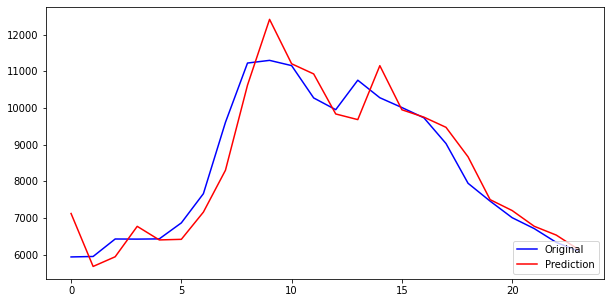

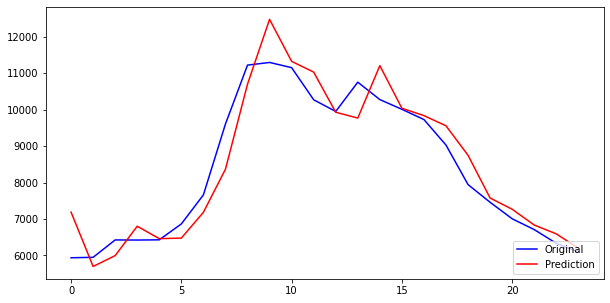

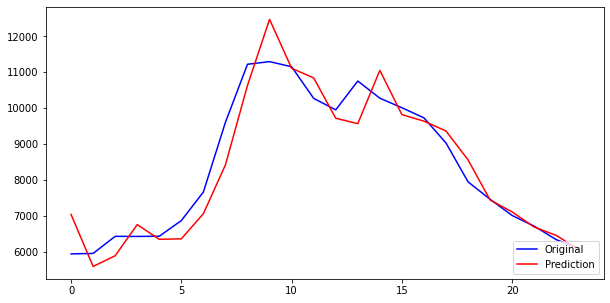

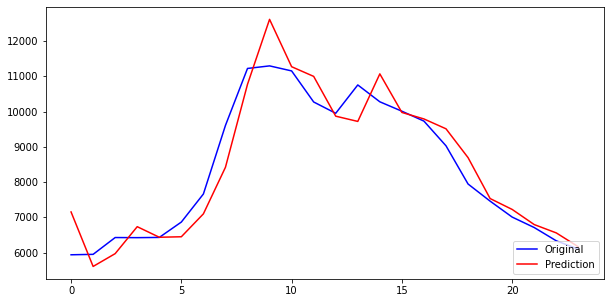

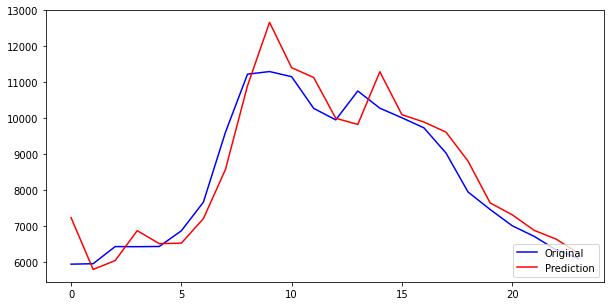

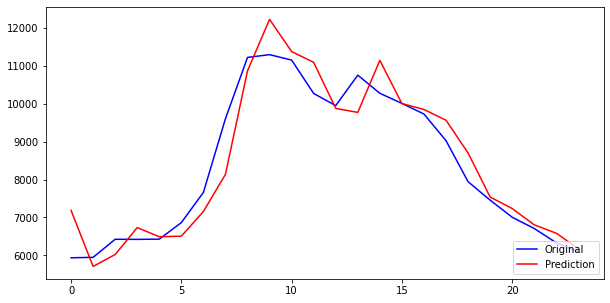

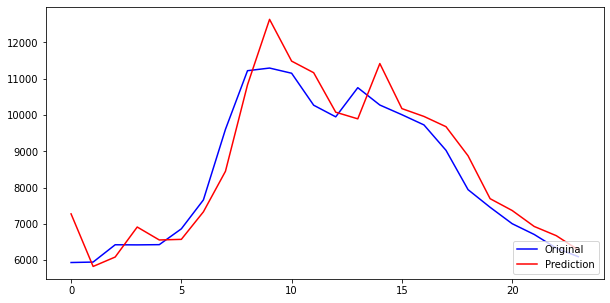

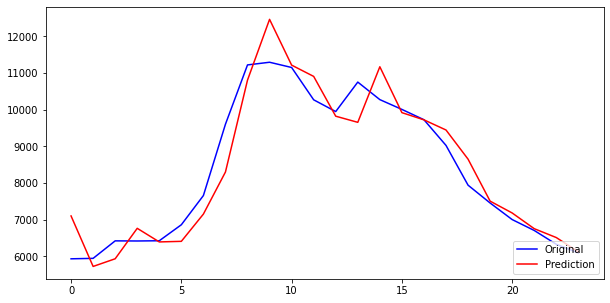

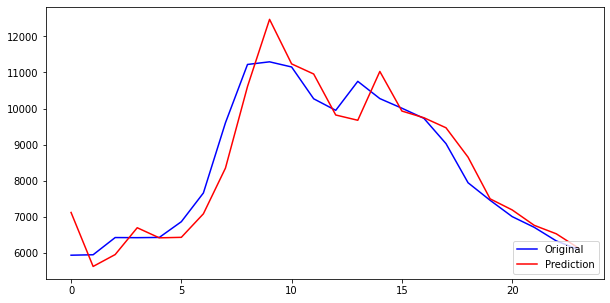

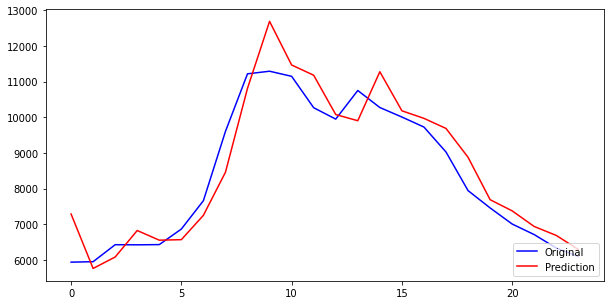

In [ ]:

# data split
n_test = 2

# define config 
# n seq: The number of subsequences within a sample.
# n steps: The number of time steps within each subsequence.
# n filters: The number of parallel filters.
# n kernel: The number of time steps considered in each read of the input sequence.
# n nodes: The number of LSTM units to use in the hidden layer.
# n epochs: The number of times to expose the model to the whole training dataset.
# n batch: The number of samples within an epoch after which the weights are updated.

config = [1, 2, 64, 3, 200, 350, 100]
# grid search
scores = repeat_evaluate(data2, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)